# <h1><b><I> General Setup

## Imports and general setup

In [1]:
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from utils3d import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
import functools
from multiprocessing import Pool, freeze_support
import multiprocessing
import pandas as pd
sys.path.append("BFCalc")

/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
astrophysicalbackground = np.load("unnormalised_astrophysicalbackground.npy")
psfnormalisationvalues = np.load("psfnormalisation.npy")
edispnormalisationvalues = np.load("edispnormalisation.npy")


In [3]:
log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitudeaxis, latitudeaxis, indexing='ij')

logjacobtrue = makelogjacob(log10eaxistrue)

print(lonmeshtrue.shape, lonmeshrecon.shape)

NameError: name 'log10eaxistrue' is not defined

## Script Parameter Setup

In [17]:
numberoftruevaluesamples = int(1e4)
Nsamples=numberoftruevaluesamples
truelambda          = 0.99
nsig                = int(round(truelambda*Nsamples))
nbkg                = int(round((1-truelambda)*Nsamples))

truelambda          = nsig/(nbkg+nsig)
numcores            = 8
truelogmassval      = 1.0

startertimer = time.perf_counter()
print(startertimer)

19.743154333


## IRF Peek

In [18]:
longitudeaxis_temp, longitudeaxistrue_temp = np.linspace(-3.5, 3.5, 1000), np.linspace(-3.5, 3.5, 10000)
psfnorm_lontrue_mesh, psfnorm_lonrecon_mesh = np.meshgrid(longitudeaxistrue, longitudeaxis, indexing='ij')

unnormedpsfvals = psf(np.array([psfnorm_lonrecon_mesh.flatten(),psfnorm_lonrecon_mesh.flatten()*0]), psfnorm_lonrecon_mesh.flatten()*0, np.array([psfnorm_lontrue_mesh.flatten(),psfnorm_lonrecon_mesh.flatten()*0])).reshape(psfnorm_lonrecon_mesh.shape)

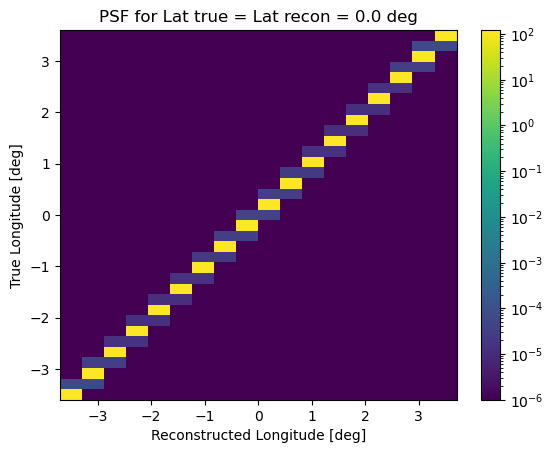

In [19]:
plt.figure()
plt.pcolormesh(longitudeaxis, longitudeaxistrue, np.exp(np.logaddexp(unnormedpsfvals.T,-300)).T, norm=LogNorm(vmin=1e-6))
plt.xlabel("Reconstructed Longitude [deg]")
plt.ylabel("True Longitude [deg]")
plt.title("PSF for Lat true = Lat recon = 0.0 deg")
plt.colorbar()
plt.show()

In [20]:
edispnorm_true, edispnorm_recon = np.meshgrid(log10eaxis,log10eaxistrue, indexing='ij')

unnormededispvals = edisp(edispnorm_recon.flatten(),edispnorm_true.flatten(), np.array([edispnorm_recon.flatten()*0+2,edispnorm_recon.flatten()*0+2])).reshape(edispnorm_recon.shape)

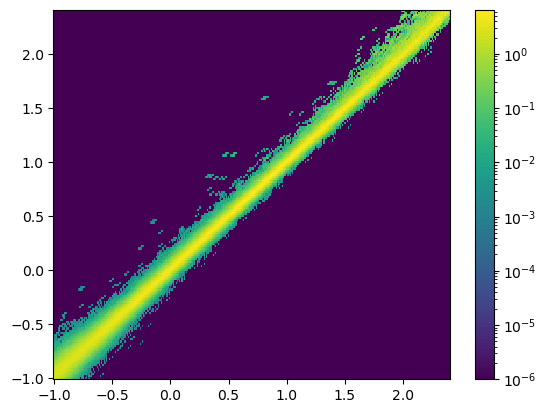

In [21]:
plt.figure()
plt.pcolormesh(log10eaxistrue, log10eaxis, np.exp(np.logaddexp(unnormededispvals,-300)), norm=LogNorm(vmin=1e-6))
plt.colorbar()

# <h1><b>Simulation

## Setup

### Background setup

In [22]:
unnormed_logbkgpriorvalues = np.logaddexp(np.squeeze(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue)),np.log(astrophysicalbackground))


logbkgpriorvalues = unnormed_logbkgpriorvalues - special.logsumexp(unnormed_logbkgpriorvalues.T+logjacobtrue)

logbkgpriorvalues.shape

(341, 35, 30)

In [10]:
# Ratio of expected events as compared to 1.08*10^8
simps(y=simps(y=simps(y=np.exp(unnormed_logbkgpriorvalues), x=10**log10eaxistrue, axis=0), x = longitudeaxistrue, axis=0), x=latitudeaxistrue)*60*60*525/1e8

342.89557881532346

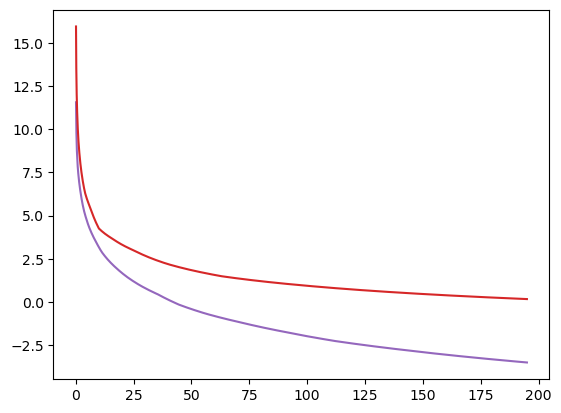

In [11]:
plt.figure()
# plt.plot(10**log10eaxistrue, special.logsumexp(logbkgpriorvalues, axis=(1,2)), c='tab:blue')
plt.plot(10**log10eaxistrue, special.logsumexp(np.log(astrophysicalbackground), axis=(1,2)), c="tab:purple")
plt.plot(10**log10eaxistrue, special.logsumexp(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue), axis=(1,2)), c="tab:red")
plt.show()

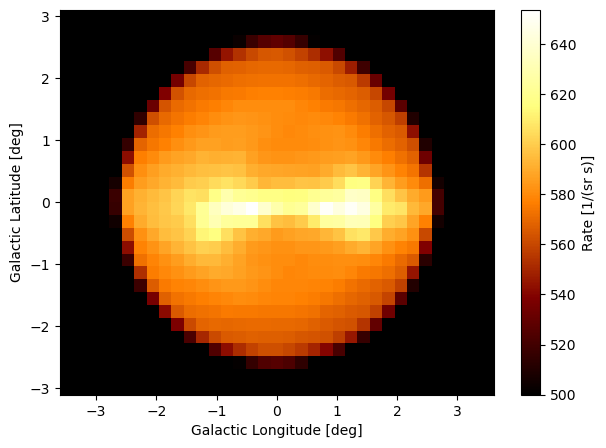

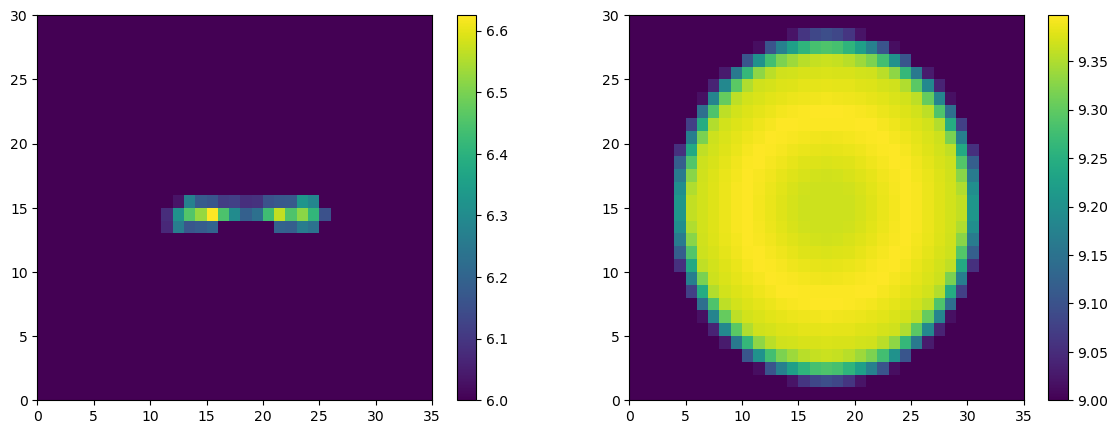

In [12]:
vminval = 9
integratedvals =  special.logsumexp(unnormed_logbkgpriorvalues.T+np.log(10**log10eaxistrue*(log10eaxistrue[1]-log10eaxistrue[0])*np.log(10)),axis=2).T
integratedmax = np.max(integratedvals)



plt.figure(figsize=(7,5), dpi=100)
otherpcol = plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(integratedvals.T), vmin=500, cmap='afmhot')
plt.colorbar(label='Rate [1/(sr s)]')
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')
plt.show()

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.pcolormesh(np.log(astrophysicalbackground)[0].T, vmin=vminval-3)
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(bkgdist(log10emeshtrue, lonmeshtrue,latmeshtrue)[0].T, vmin=vminval)
plt.colorbar()
plt.show()

In [13]:
fig,axs = plt.subplots(4,5, figsize=(14,10), dpi=500)


maxval = np.max(logbkgpriorvalues)


spaceconverter = int(np.round(longitudeaxistrue.shape[0]/6))
axs[0,0].pcolormesh(log10eaxistrue, longitudeaxistrue, logbkgpriorvalues[:,:,0].T, 
                    vmin = maxval-20, vmax=maxval, cmap='afmhot')
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(5):
    axs[0,index].pcolormesh(log10eaxistrue, longitudeaxistrue, logbkgpriorvalues[:,:,index*spaceconverter].T, 
                            vmin = maxval-20, vmax=maxval, cmap='afmhot')
    axs[0,index].set_title(f"Lat = {np.round(longitudeaxistrue[index*spaceconverter],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = int(np.round(log10eaxistrue.shape[0]/5))
axs[1,0].pcolormesh(longitudeaxistrue, latitudeaxistrue, logbkgpriorvalues[0,:,:].T, 
                    vmin = maxval-20, vmax=maxval, cmap='afmhot')
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[0*logeconverter],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,5):
    pcol = axs[1,jndex].pcolormesh(longitudeaxistrue, latitudeaxistrue, logbkgpriorvalues[jndex*logeconverter,:,:].T, 
                                   vmin = maxval-20, vmax=maxval, cmap='afmhot')
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[jndex*logeconverter],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logbkgpriorvalues,axis=(1,2)))
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,7,11)
plt.axis('off')
plt.text(x=0,y=0.5,s="""This is a (stupid) representation 
of 3d background model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logbkgpriorvalues.T+np.log(10**log10eaxistrue*(log10eaxistrue[1]-log10eaxistrue[0])*np.log(10)),axis=2).T
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(integratedvals.T), norm=LogNorm(vmin = np.exp(integratedmax-0.4), vmax=np.exp(integratedmax)), cmap='afmhot')
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', 
             ticks=np.arange(np.round(maxval-20),np.round(maxval), 3))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', 
             ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 2))


plt.suptitle('3D Background Model', y=1.05, size=32)
# fig.tight_layout(pad=5.0)
plt.show()

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_65493/2896621179.py:42: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_65493/2896621179.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)


KeyboardInterrupt: 

### Signal Setup

In [ ]:
darkSUSY_to_Gammapy_converter = {
    "nuenue":"nu_e",
    "e+e-": "e",
    "numunumu":"nu_mu",
    "mu+mu-":"mu",
    'nutaunutau':"nu_tau",
    "tau+tau-":"tau",
    "cc": "c",
    "bb": "b",
    "tt": "t",
    "W+W-": "W",
    "ZZ": "Z",
    "gg": "g",
    "gammagamma": "gamma",
    "HH": "h",
}

darkSUSY_BFs_cleaned = pd.read_csv('BFCalc/darkSUSY_BFs/darkSUSY_BFs_cleaned.csv', delimiter=' ')

darkSUSY_massvalues = darkSUSY_BFs_cleaned.iloc[:,1]/1e3

darkSUSY_lambdavalues = darkSUSY_BFs_cleaned.iloc[:,2]

channelfuncdictionary = {}

modulefolderpath = 'BFCalc'
log10xvals = np.load(modulefolderpath+f"/griddata/log10xvals_massenergy_diffflux_grid.npy")
massvalues = np.load(modulefolderpath+f"/griddata/massvals_massenergy_diffflux_grid.npy")

for darkSUSYchannel in list(darkSUSY_to_Gammapy_converter.keys()):
    try:
        gammapychannel = darkSUSY_to_Gammapy_converter[darkSUSYchannel]
        
        tempspectragrid = np.load(modulefolderpath+f"/griddata/channel={gammapychannel}_massenergy_diffflux_grid.npy")
        
        channelfuncdictionary[darkSUSYchannel] = interpolate.interp2d(np.log10(massvalues/1e3), log10xvals, np.array(tempspectragrid).T, 
                                    kind='linear', bounds_error=False, fill_value=1e-3000)
    except:
        channelfuncdictionary[darkSUSYchannel] = lambda logmass, log10x: log10x*0


partial_sigmav_interpolator_dictionary = {channel: interpolate.LinearNDInterpolator((darkSUSY_massvalues, darkSUSY_lambdavalues),darkSUSY_BFs_cleaned.iloc[:,idx+3]) for idx, channel in enumerate(list(darkSUSY_to_Gammapy_converter.keys()))}



def nontrivial_coupling(logmass, logenergy, coupling=0.1, partial_sigmav_interpolator_dictionary=partial_sigmav_interpolator_dictionary, channelfuncdictionary=channelfuncdictionary ):
    
    logspectra = -np.inf
    for channel in channelfuncdictionary.keys():
        logspectra = np.logaddexp(logspectra, np.log(partial_sigmav_interpolator_dictionary[channel](10**logmass, coupling)*channelfuncdictionary[channel](logmass, logenergy-logmass)))
        
    return logspectra
        
    
    



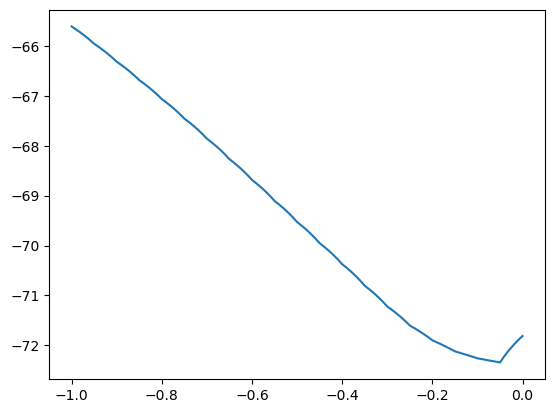

In [ ]:
plt.figure()
plt.plot(log10eaxistrue, nontrivial_coupling(0.0, log10eaxistrue))
plt.show()

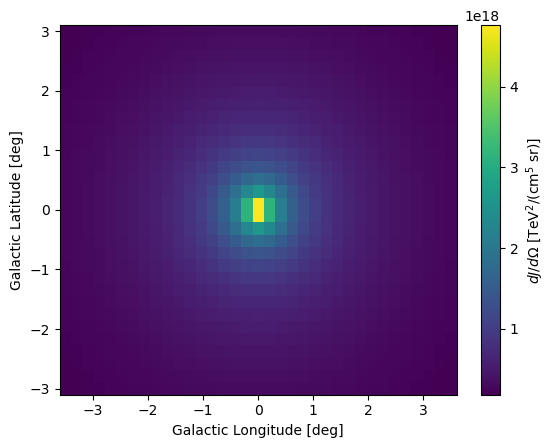

In [ ]:
from gammapy.astro.darkmatter import (
    profiles,
    JFactory
)



profile = profiles.EinastoProfile()

# Adopt standard values used in HESS
profiles.DMProfile.DISTANCE_GC = 8.5 * u.kpc
profiles.DMProfile.LOCAL_DENSITY = 0.39 * u.Unit("GeV / cm3")

profile.scale_to_local_density()

position = SkyCoord(0.0, 0.0, frame="galactic", unit="deg")
geom = WcsGeom.create(skydir=position, 
                      binsz=(longitudeaxistrue[1]-longitudeaxistrue[0],latitudeaxistrue[1]-latitudeaxistrue[0]),
                      width=(longitudeaxistrue[-1]-longitudeaxistrue[0]+longitudeaxistrue[1]-longitudeaxistrue[0], latitudeaxistrue[-1]-latitudeaxistrue[0]+latitudeaxistrue[1]-latitudeaxistrue[0]),
                      frame="galactic")


jfactory = JFactory(
    geom=geom, profile=profile, distance=profiles.DMProfile.DISTANCE_GC
)
jfact = jfactory.compute_differential_jfactor().to(u.TeV**2/u.cm**5/u.sr).value


plt.figure()
plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, jfact)
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')
plt.colorbar(label=r'$dJ/d\Omega$ [TeV$^2$/(cm$^5$ sr)]')
plt.show()

In [ ]:
signalspecfunc = nontrivial_coupling
signalfunc = setup_full_fake_signal_dist(truelogmassval, signalspecfunc)
truelogmassval

1.0

In [ ]:
log10emeshtrue.shape

(341, 35, 30)

In [ ]:
logsigpriorvalues = signalfunc(log10emeshtrue, lonmeshtrue,latmeshtrue)

print(logsigpriorvalues.shape)

logsigpriorvalues = (logsigpriorvalues - special.logsumexp(logsigpriorvalues.T+logjacobtrue))
logsigpriorvalues.shape

(341, 35, 30)


(341, 35, 30)

In [ ]:
np.mean(jfact)

5.0471803697404416e+17

In [ ]:
lonmeshtrue[:,0,0]

array([-3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5,
       -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3.5, -3

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/366895901.py:41: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/366895901.py:48: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,14,22)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/366895901.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,3,6)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/366895901.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so result

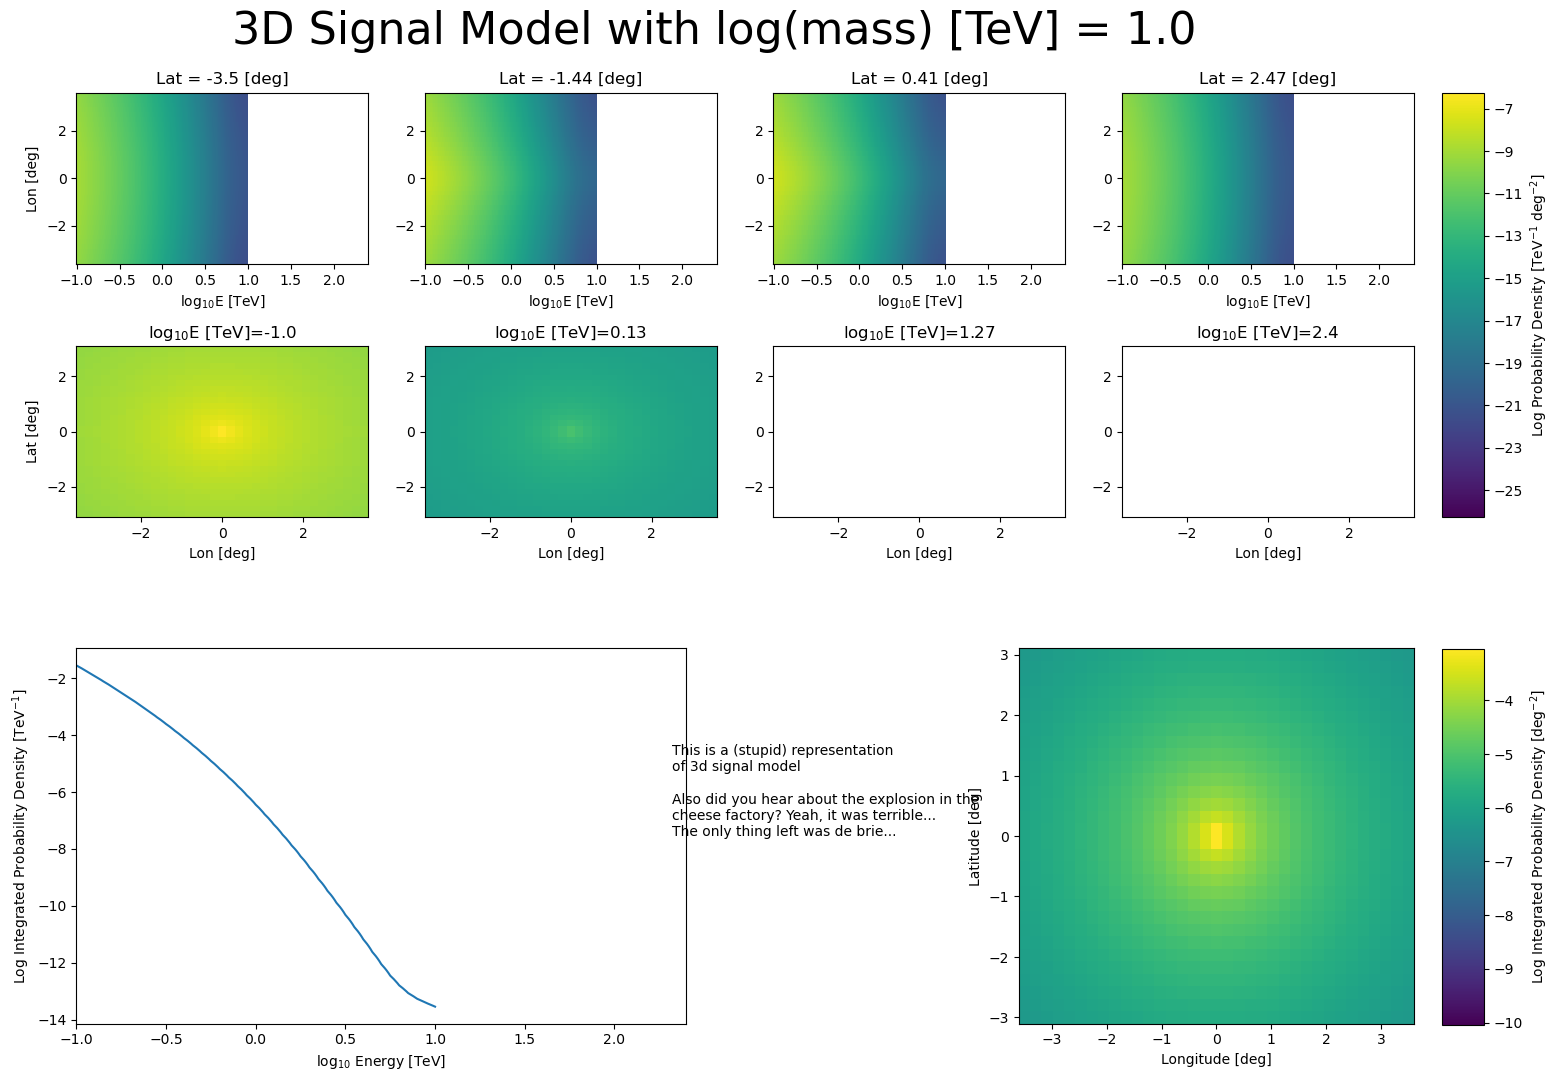

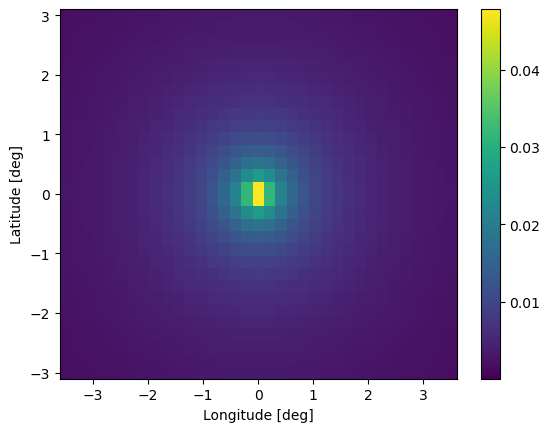

In [ ]:
numslices = 4
fig,axs = plt.subplots(4,numslices, figsize=(14,10))


maxval = np.max(logsigpriorvalues)

spaceconverter = np.round(np.linspace(0, latitudeaxistrue.shape[0]-1,numslices))


axs[0,0].pcolormesh(log10eaxistrue, longitudeaxistrue, logsigpriorvalues[:,:,0].T, vmin = maxval-20, vmax=maxval)
axs[0,0].set_ylabel('Lon [deg]')
axs[0,0].set_xlabel(r'log$_{10}$E [TeV]')

for index in range(numslices):
    axs[0,index].pcolormesh(log10eaxistrue, longitudeaxistrue, logsigpriorvalues[:,:,int(spaceconverter[index])].T, vmin = maxval-20, vmax=maxval)
    axs[0,index].set_title(f"Lat = {np.round(longitudeaxistrue[int(spaceconverter[index])],2)} [deg]")
    axs[0,index].set_xlabel(r'log$_{10}$E [TeV]')

    
logeconverter = np.round(np.linspace(0, log10eaxistrue.shape[0]-1,numslices))

axs[1,0].pcolormesh(longitudeaxistrue, latitudeaxistrue, logsigpriorvalues[0,:,:].T, vmin = maxval-20, vmax=maxval)
axs[1,0].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[0])],2)}")
axs[1,0].set_ylabel('Lat [deg]')
axs[1,0].set_xlabel('Lon [deg]')

for jndex in range(1,numslices):
    pcol = axs[1,jndex].pcolormesh(longitudeaxistrue, latitudeaxistrue, logsigpriorvalues[int(logeconverter[jndex]),:,:].T, vmin = maxval-20, vmax=maxval)
    axs[1,jndex].set_title(r'log$_{10}$E [TeV]='+ f"{np.round(log10eaxistrue[int(logeconverter[jndex])],2)}")
    axs[1,jndex].set_xlabel('Lon [deg]')

    
fig.tight_layout(pad=0.9)

for axis in axs[2,:]:
    axis.axis('off')
    
for axis in axs[3,:]:
    axis.axis('off')
    
plt.subplot(2,2,3)
plt.plot(log10eaxistrue, special.logsumexp(logsigpriorvalues,axis=(1,2)))
plt.xlim([log10eaxistrue[0],log10eaxistrue[-1]])
plt.ylabel('Log Integrated Probability Density [TeV$^{-1}$]')
plt.xlabel(r'log$_{10}$ Energy [TeV]')


plt.subplot(2,14,22)
plt.axis('off')
plt.text(x=-1,y=0.5,s="""This is a (stupid) representation 
of 3d signal model
         
Also did you hear about the explosion in the 
cheese factory? Yeah, it was terrible... 
The only thing left was de brie...""")

integratedvals =  special.logsumexp(logsigpriorvalues,axis=0)
integratedmax = np.max(integratedvals)
plt.subplot(2,3,6)
otherpcol = plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, integratedvals.T, vmin = integratedmax-7, vmax=integratedmax)
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')


fig.subplots_adjust(right=1.0)
cbar_ax = fig.add_axes([1.02, 0.543, 0.03, 0.424])
fig.colorbar(pcol, cax=cbar_ax, label=r'Log Probability Density [TeV$^{-1}$ deg$^{-2}$]', ticks=np.arange(np.round(maxval-20)-1,np.round(maxval)+1, 2))

cbar_ax2 = fig.add_axes([1.02, 0.0352, 0.03, 0.376])
fig.colorbar(otherpcol, cax=cbar_ax2, label=r'Log Integrated Probability Density [deg$^{-2}$]', ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 1))
plt.suptitle(f'3D Signal Model with log(mass) [TeV] = {truelogmassval}', y=1.05, size=32)

fig.tight_layout()
plt.show()


plt.figure()
otherpcol = plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, np.exp(integratedvals.T), vmin = np.exp(integratedmax-7), vmax=np.exp(integratedmax))
plt.colorbar(otherpcol)#, label=r'Log Integrated Probability Density [deg$^{-2}$]', ticks=np.arange(np.round(integratedmax-7),np.round(integratedmax), 1))
plt.ylabel('Latitude [deg]')
plt.xlabel('Longitude [deg]')
plt.show()


In [ ]:

    
    
# signalfraction_test_vals = np.linspace(0,1,101)
# bkgmap = astrophysicalbackground[0].T/np.exp(special.logsumexp(np.log(astrophysicalbackground[0].T)))
# sigmap = integratedvals.T
# sigmap = np.exp(sigmap - special.logsumexp(sigmap))

# os.system('rm -rf Figures/giffolder')
# os.system('mkdir Figures/giffolder')

# for fracval in tqdm(signalfraction_test_vals):
#     plt.figure(figsize=(8,6))
#     plt.title(r'$\xi$ = '+f'{round(fracval,3):.3f}')
#     plt.pcolormesh(longitudeaxistrue, latitudeaxistrue, fracval*sigmap+(1-fracval)*bkgmap, 
#                norm=LogNorm(vmin=1e-4,vmax=1e-2), shading='auto', antialiased=True)
#     plt.xlabel('Galactic Longitude [deg]')
#     plt.ylabel('Galactic Latitude [deg]')
#     pcol.set_edgecolor('face')

#     # plt.colorbar()
#     plt.savefig(f'Figures/giffolder/{fracval}plot.png', dpi=300, bbox_inches='tight')
#     plt.close()
    
# import os
# import imageio

# # Directory containing your plot images
# image_directory = 'Figures/giffolder/'

# # List all image files in the directory
# image_files = sorted([f for f in os.listdir(image_directory) if f.endswith('.png')])


# # Create a list to store the images
# images = []
# for image_file in image_files:
#     image_path = os.path.join(image_directory, image_file)
#     images.append(imageio.imread(image_path))

# # Output GIF file name and path
# output_gif = 'Figures/my_awesome.gif'

# # Create the GIF
# imageio.mimsave(output_gif, images, format='GIF', duration=1)  # You can adjust the duration as needed (in seconds)

# print(f'GIF saved as {output_gif}')

## True Value Simulation

In [ ]:
logsigbinnedprior = (logsigpriorvalues.T+logjacobtrue).T
flattened_logsigbinnedprior = logsigbinnedprior.flatten()


logbkgbinnedprior = (logbkgpriorvalues.T+logjacobtrue).T
flattened_logbkgbinnedprior = logbkgbinnedprior.flatten()

In [ ]:

if truelambda!=0.0:
    sigresultindices = np.unravel_index(inverse_transform_sampling(flattened_logsigbinnedprior, Nsamples=nsig),logsigbinnedprior.shape)
    siglogevals = log10eaxistrue[sigresultindices[0]]
    siglonvals = longitudeaxistrue[sigresultindices[1]]
    siglatvals = latitudeaxistrue[sigresultindices[2]]
else:
    siglogevals = np.asarray([])
    siglonvals = np.asarray([])
    siglatvals = np.asarray([])

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/2636887125.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/2636887125.py:29: RuntimeWarning: invalid value encountered in true_divide
  ratios = signalplotvalues_intermediate[1:]/sigspechistvals[0]
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/2636887125.py:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/2636887125.py:41: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


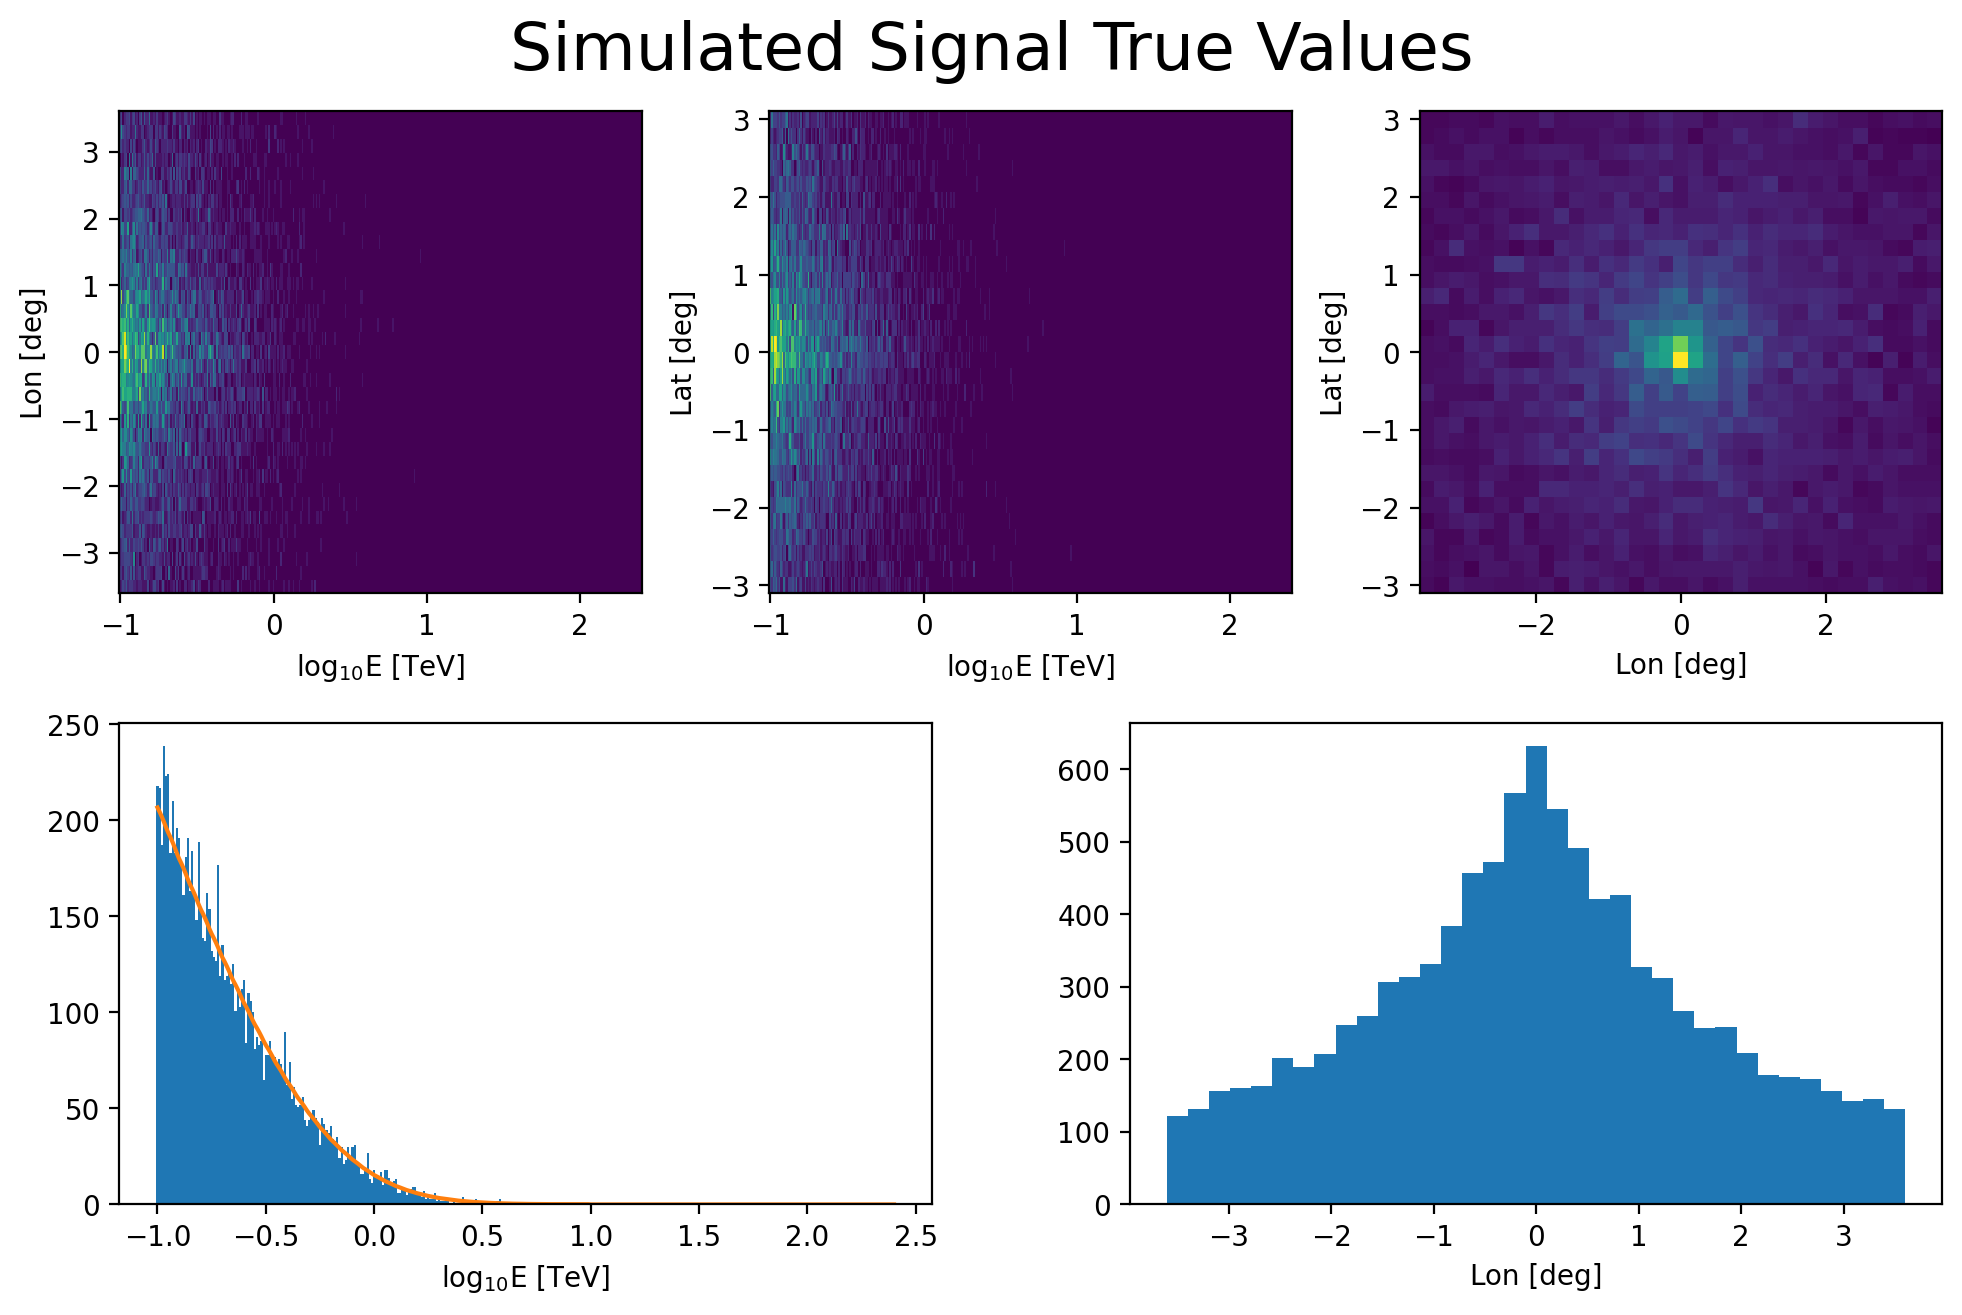

In [ ]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(siglogevals, siglonvals, bins=[plotlog10eaxistrue,plotlongitudeaxistrue])
plt.ylabel('Lon [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,3,2)
plt.hist2d(siglogevals, siglatvals, bins=[plotlog10eaxistrue,plotlatitudeaxistrue])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lat [deg]')



plt.subplot(2,3,3)
plt.hist2d(siglonvals, siglatvals, bins=[plotlongitudeaxistrue,plotlatitudeaxistrue])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)

sigspecvals = np.squeeze(np.exp(makelogjacob(plotlog10eaxistrue)+np.squeeze(signalspecfunc(truelogmassval, plotlog10eaxistrue))))
plt.subplot(2,2,3)
sigspechistvals = plt.hist(siglogevals, bins=plotlog10eaxistrue)
signalplotvalues_intermediate = sigspecvals/np.max(sigspecvals)*np.max(sigspechistvals[0])

ratios = signalplotvalues_intermediate[1:]/sigspechistvals[0]
ratios = ratios[~np.isinf(ratios)]
averagediffratio = np.nanmean(ratios)
plt.plot(log10eaxistrue, signalplotvalues_intermediate[1:]/averagediffratio)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(siglonvals, bins=plotlongitudeaxistrue)
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)

plt.suptitle("Simulated Signal True Values", y=1.05, size=24)
plt.show()

In [ ]:
bkgresultindices = np.unravel_index(inverse_transform_sampling(flattened_logbkgbinnedprior, Nsamples=nbkg),logbkgbinnedprior.shape)
bkglogevals = log10eaxistrue[bkgresultindices[0]]
bkglonvals = longitudeaxistrue[bkgresultindices[1]]
bkglatvals = latitudeaxistrue[bkgresultindices[2]]

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/3501848987.py:26: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/3501848987.py:29: RuntimeWarning: invalid value encountered in true_divide
  bkgaveragediffratio = np.nanmean(bkgspechistvals[0]/backgroundplotvalues_intermediate[1:])
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/3501848987.py:36: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/3501848987.py:41: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_lay

0.5271903833572786


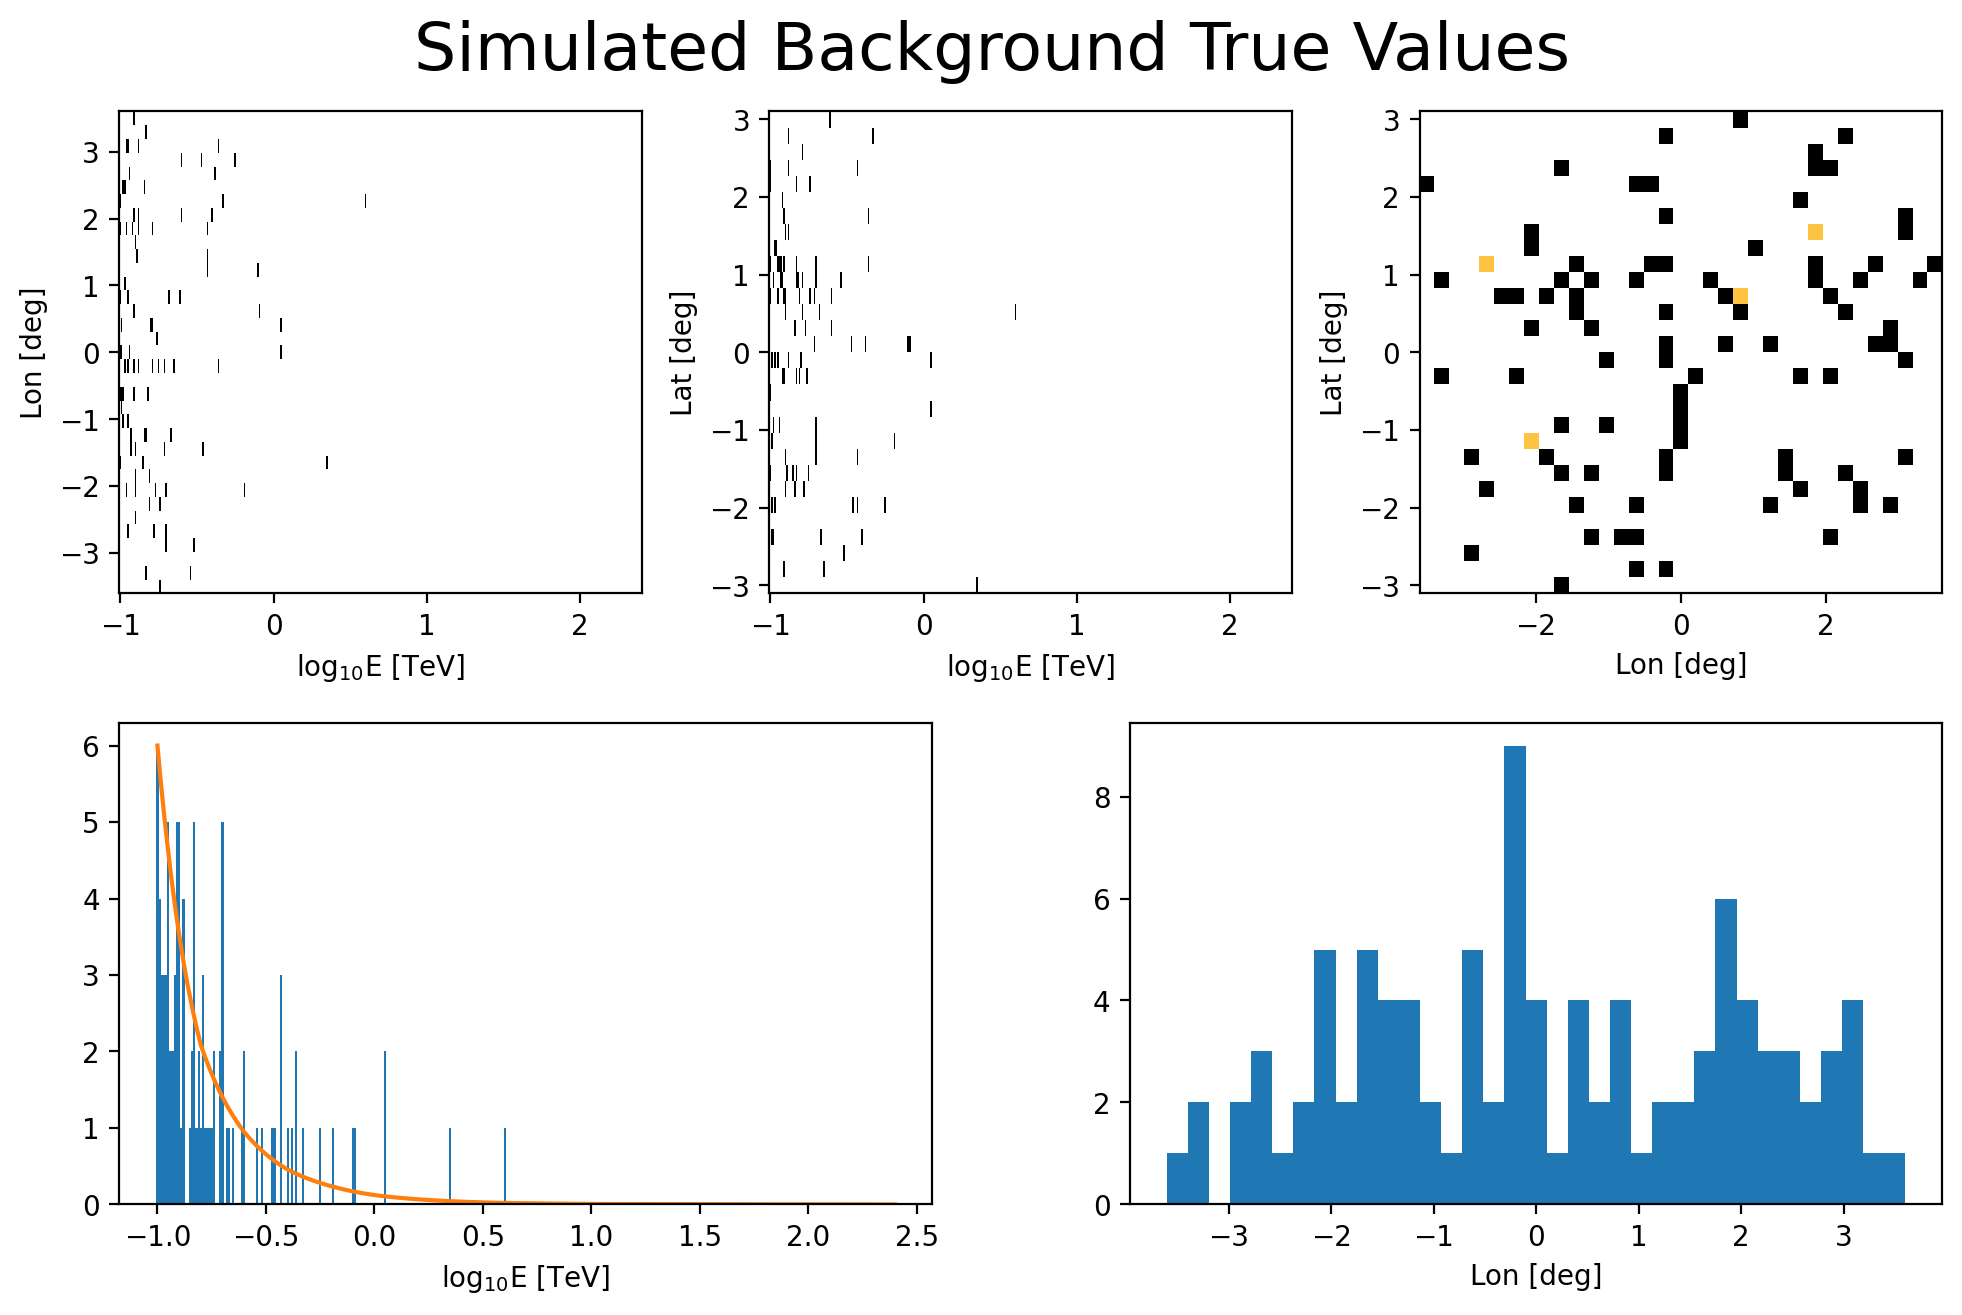

In [ ]:
plt.subplots(2,3,dpi=200,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(bkglogevals, bkglonvals, bins=[plotlog10eaxistrue,plotlongitudeaxistrue], cmap='afmhot', norm=LogNorm())
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lon [deg]')


plt.subplot(2,3,2)
plt.hist2d(bkglogevals, bkglatvals, bins=[plotlog10eaxistrue,plotlatitudeaxistrue], cmap='afmhot', norm=LogNorm())
plt.ylabel('Lat [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')


plt.subplot(2,3,3)
plt.hist2d(bkglonvals, bkglatvals, bins=[plotlongitudeaxistrue,plotlatitudeaxistrue], cmap='afmhot', norm=LogNorm())
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)


logbkgspecvals = special.logsumexp(makelogjacob(plotlog10eaxistrue[:-1])+logbkgpriorvalues.T, axis=(0,1))
bkgspecvals = np.squeeze(np.exp(logbkgspecvals-special.logsumexp(logbkgspecvals)))

plt.subplot(2,2,3)
bkgspechistvals =plt.hist(bkglogevals, bins=plotlog10eaxistrue[:-1])
backgroundplotvalues_intermediate = bkgspecvals/np.max(bkgspecvals)*np.max(bkgspechistvals[0])
bkgaveragediffratio = np.nanmean(bkgspechistvals[0]/backgroundplotvalues_intermediate[1:])
print(bkgaveragediffratio)
plt.plot(log10eaxistrue, backgroundplotvalues_intermediate)#*bkgaveragediffratio)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(bkglonvals, bins=plotlongitudeaxistrue)
plt.xlabel('Lon [deg]')


plt.tight_layout(pad=1.0)


plt.suptitle("Simulated Background True Values", y=1.05, size=24)

plt.show()

## Reconstructed Value Simulation

In [ ]:
lonmeshrecon.shape

(18, 15)

In [ ]:
for coord in np.array([siglonvals, siglatvals]).T:
    print(coord)

[-3.29411765 -0.31034483]
[ 0.82352941 -1.96551724]
[3.5        0.51724138]
[ 0.20588235 -0.93103448]
[-1.64705882  0.72413793]
[-2.47058824 -0.31034483]
[ 0.20588235 -1.96551724]
[-2.47058824 -2.5862069 ]
[-2.67647059  2.5862069 ]
[ 0.61764706 -0.31034483]
[ 1.02941176 -0.93103448]
[-0.82352941 -0.51724138]
[0.20588235 0.51724138]
[-2.47058824 -1.34482759]
[-3.08823529  1.34482759]
[-0.41176471 -0.10344828]
[-2.05882353 -2.5862069 ]
[-3.29411765  0.31034483]
[3.5 3. ]
[1.23529412 1.34482759]
[-0.20588235  0.72413793]
[-0.20588235  0.10344828]
[-3.08823529  0.31034483]
[2.47058824 0.72413793]
[-0.41176471  1.34482759]
[ 0.82352941 -0.51724138]
[ 3.5        -1.96551724]
[-0.82352941 -2.37931034]
[ 2.88235294 -0.72413793]
[-1.64705882  0.93103448]
[ 0.82352941 -2.37931034]
[0.61764706 0.93103448]
[0.         1.13793103]
[-0.61764706  0.10344828]
[-1.02941176  0.72413793]
[0.20588235 0.10344828]
[-3.08823529 -1.13793103]
[-0.20588235  1.55172414]
[0.20588235 1.13793103]
[0.41176471 0.5172

### Signal

In [ ]:

if truelambda!=0.0:
    signal_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, coord)+logjacob, Nsamples=1) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)])]
else:
    signal_log10e_measured = np.asarray([])

100%|██████████| 9900/9900 [00:05<00:00, 1847.69it/s]


In [ ]:

if truelambda!=0:
    signal_spatial_indices = np.squeeze([inverse_transform_sampling(psf(np.array([lonmeshrecon.flatten(), latmeshrecon.flatten()]), logeval, coord).flatten(), Nsamples=1) for logeval, coord in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)])
    signal_reshaped_indices = np.unravel_index(signal_spatial_indices, shape=lonmeshrecon.shape)
    signal_lon_measured = longitudeaxis[signal_reshaped_indices[0]]
    signal_lat_measured = latitudeaxis[signal_reshaped_indices[1]]
else:
    signal_lon_measured = np.asarray([])
    signal_lat_measured = np.asarray([])


100%|██████████| 9900/9900 [00:57<00:00, 172.47it/s]


In [ ]:
# np.max(signal_reshaped_indices[1])

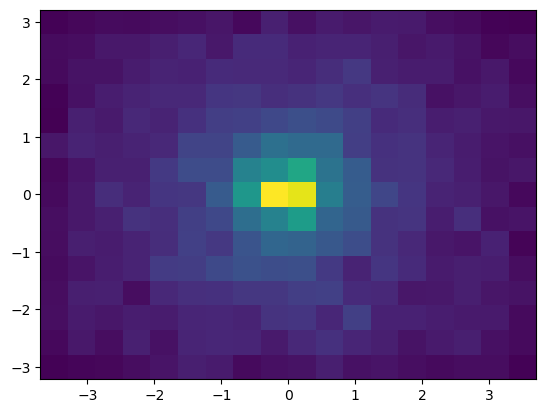

In [ ]:
plt.figure()
plt.hist2d(signal_lon_measured, signal_lat_measured, bins=[plotlongitudeaxis, plotlatitudeaxis])
plt.show()

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/2887056561.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/2887056561.py:30: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/2887056561.py:35: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


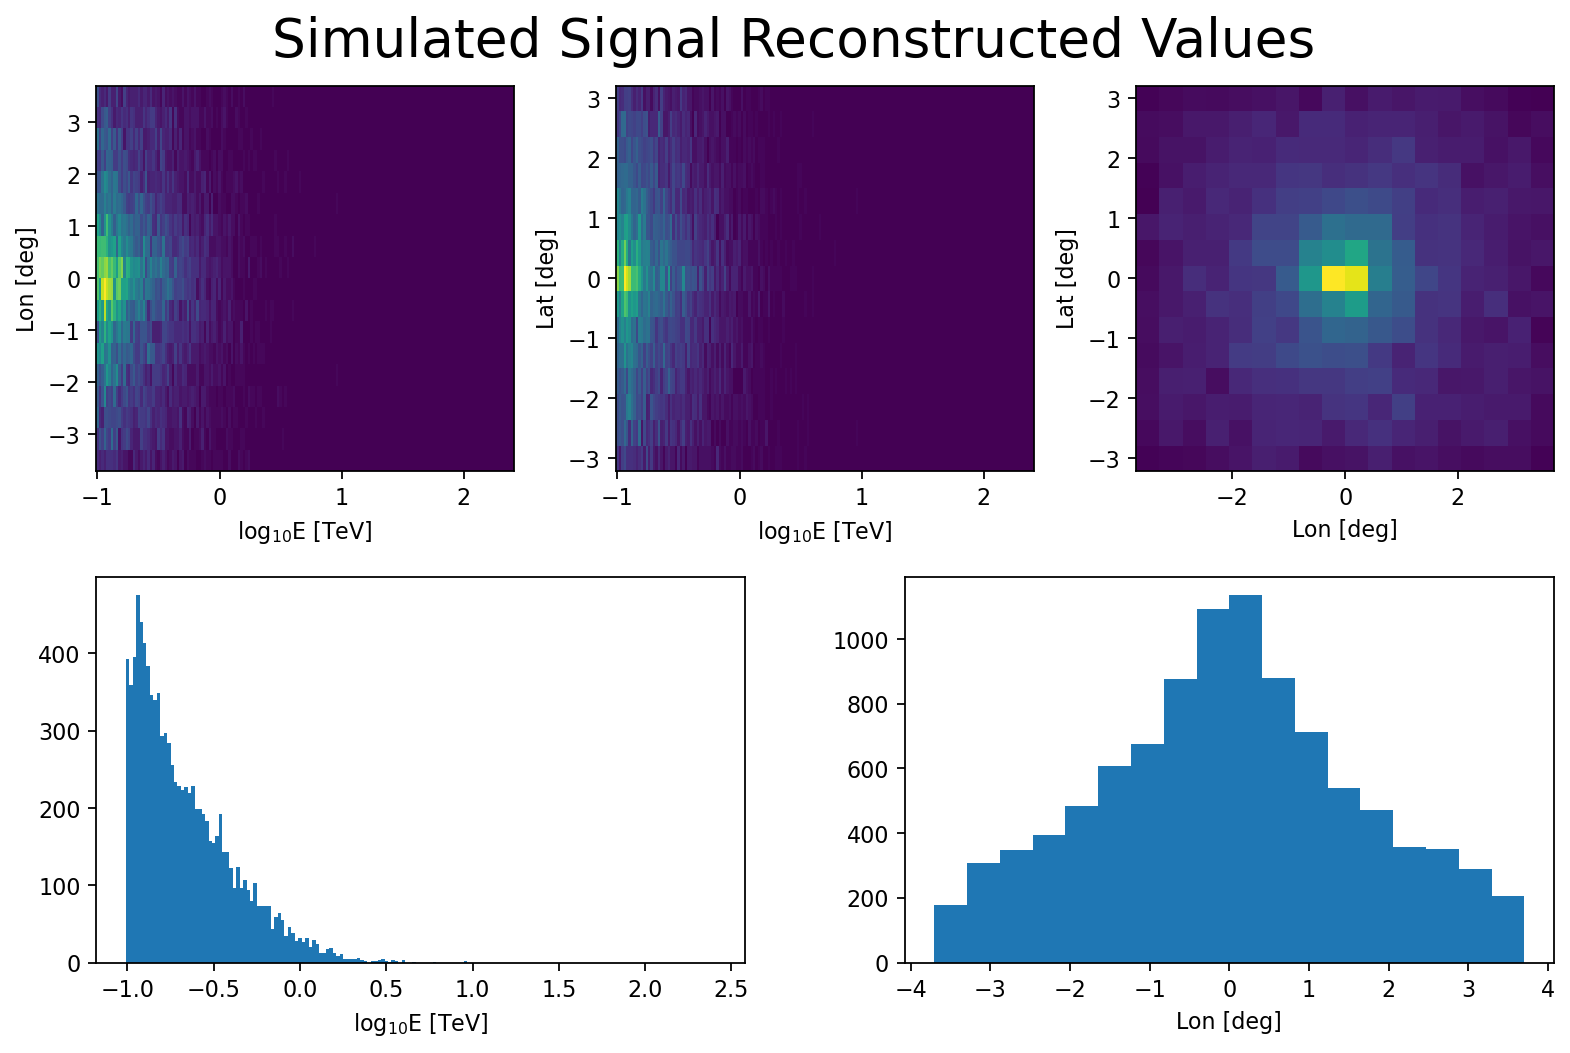

In [ ]:
plt.subplots(2,3,dpi=160,figsize=(10,6))

plt.subplot(2,3,1)
plt.hist2d(signal_log10e_measured, signal_lon_measured, bins=[plotlog10eaxis,plotlongitudeaxis])
plt.xlabel(r'log$_{10}$E [TeV]')
plt.ylabel('Lon [deg]')


plt.subplot(2,3,2)
plt.hist2d(signal_log10e_measured, signal_lat_measured, bins=[plotlog10eaxis,plotlatitudeaxis])
plt.ylabel('Lat [deg]')
plt.xlabel(r'log$_{10}$E [TeV]')


plt.subplot(2,3,3)
plt.hist2d(signal_lon_measured, signal_lat_measured, bins=[plotlongitudeaxis, plotlatitudeaxis])
plt.ylabel('Lat [deg]')
plt.xlabel('Lon [deg]')

plt.tight_layout(pad=1.0)



plt.subplot(2,2,3)
plt.hist(signal_log10e_measured, bins=plotlog10eaxis)
plt.xlabel(r'log$_{10}$E [TeV]')



plt.subplot(2,2,4)
plt.hist(signal_lon_measured, bins=plotlongitudeaxis)
plt.xlabel('Lon [deg]')


plt.tight_layout(pad=1.0)


plt.suptitle("Simulated Signal Reconstructed Values", y=1.05, size=24)

plt.show()

### Background

In [ ]:
bkg_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, coord)+logjacob, Nsamples=1) for logeval,coord  in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)])]

100%|██████████| 100/100 [00:00<00:00, 1744.98it/s]


In [ ]:
bkg_spatial_indices = np.squeeze([inverse_transform_sampling(psf(np.array([lonmeshrecon.flatten(), latmeshrecon.flatten()]), logeval, coord).flatten(), Nsamples=1) for logeval, coord in notebook_tqdm(zip(bkglogevals, np.array([bkglonvals, bkglatvals]).T), total=nbkg)])
bkg_reshaped_indices = np.unravel_index(bkg_spatial_indices, shape=lonmeshrecon.shape)
bkg_lon_measured = longitudeaxis[bkg_reshaped_indices[0]]
bkg_lat_measured = latitudeaxis[bkg_reshaped_indices[1]]


100%|██████████| 100/100 [00:00<00:00, 173.76it/s]


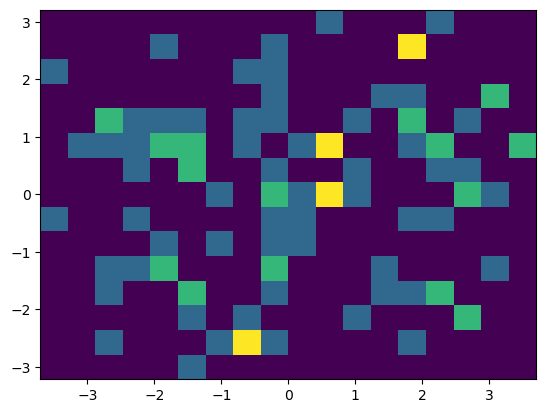

In [ ]:
try:
    plt.figure()
    plt.hist2d(bkg_lon_measured, bkg_lat_measured, bins=[plotlongitudeaxis,plotlatitudeaxis])
    plt.show()
except:
    pass

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/4251250309.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,3)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/4251250309.py:31: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,4)
/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/4251250309.py:36: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout(pad=1.0)


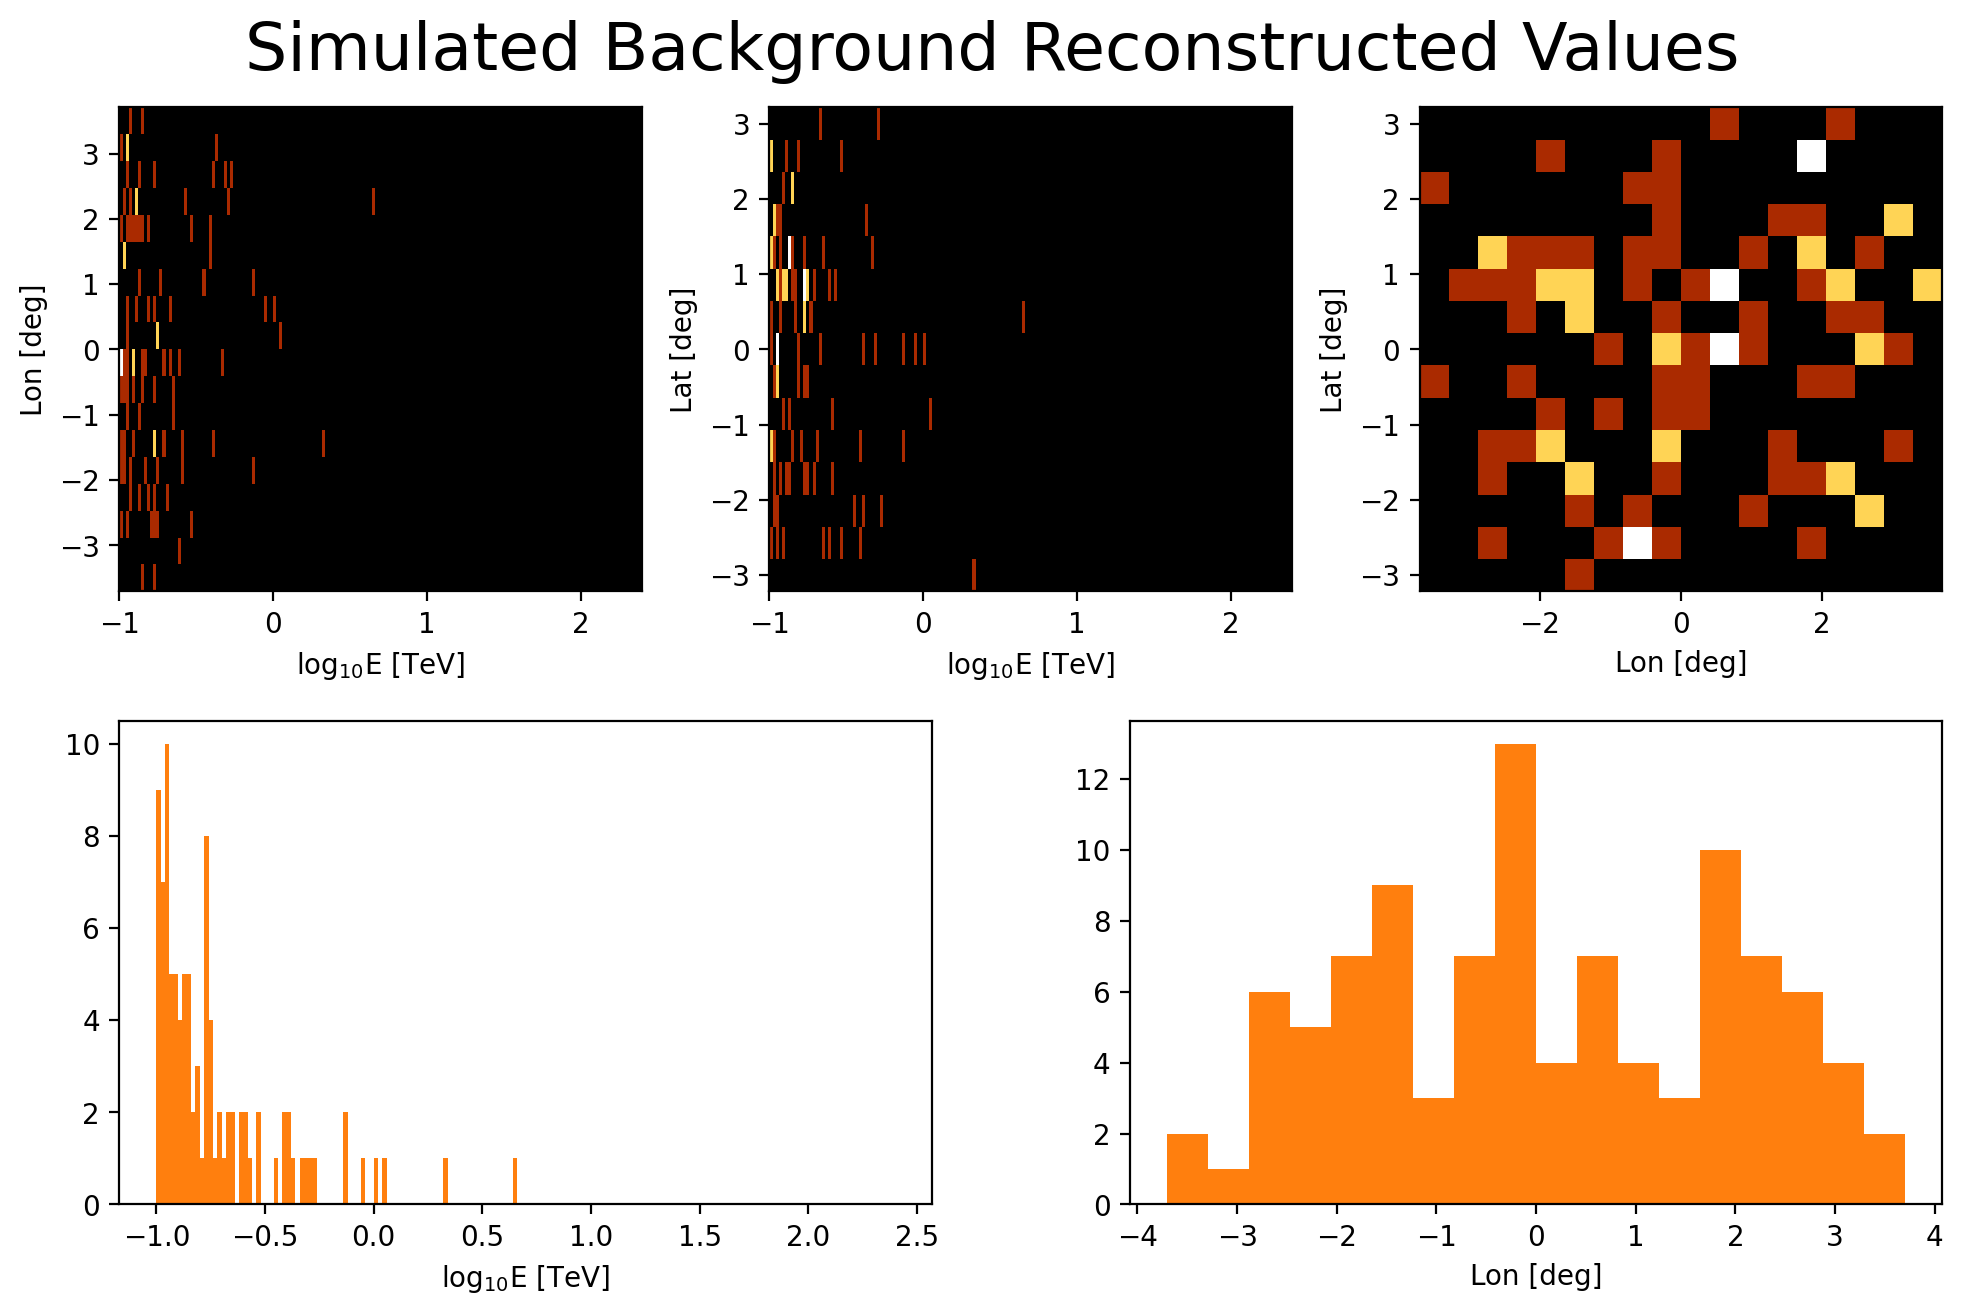

In [ ]:

try:
    plt.subplots(2,3,dpi=200,figsize=(10,6))

    plt.subplot(2,3,1)
    plt.hist2d(bkg_log10e_measured, bkg_lon_measured, bins=[log10eaxis,plotlongitudeaxis], cmap='afmhot')
    plt.xlabel(r'log$_{10}$E [TeV]')
    plt.ylabel('Lon [deg]')


    plt.subplot(2,3,2)
    plt.hist2d(bkg_log10e_measured, bkg_lat_measured, bins=[log10eaxis,plotlatitudeaxis], cmap='afmhot')
    plt.ylabel('Lat [deg]')
    plt.xlabel(r'log$_{10}$E [TeV]')


    plt.subplot(2,3,3)
    plt.hist2d(bkg_lon_measured, bkg_lat_measured, bins=[plotlongitudeaxis,plotlatitudeaxis], cmap='afmhot')
    plt.ylabel('Lat [deg]')
    plt.xlabel('Lon [deg]')

    plt.tight_layout(pad=1.0)



    plt.subplot(2,2,3)
    plt.hist(bkg_log10e_measured, bins=log10eaxis, color='tab:orange')
    plt.xlabel(r'log$_{10}$E [TeV]')



    plt.subplot(2,2,4)
    plt.hist(bkg_lon_measured, bins=plotlongitudeaxis, color='tab:orange')
    plt.xlabel('Lon [deg]')


    plt.tight_layout(pad=1.0)


    plt.suptitle("Simulated Background Reconstructed Values", y=1.05, size=24)

    plt.show()
except:
    pass

## Final simulation output

In [ ]:


try:
    measured_log10e = list(signal_log10e_measured)+list(bkg_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
    measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)
    
except:
    if type(bkg_log10e_measured)==np.float64:
        measured_log10e = list(signal_log10e_measured)
        measured_lon = list(signal_lon_measured)
        measured_lat = list(signal_lat_measured)
        measured_log10e.append(bkg_log10e_measured)
        measured_lon.append(bkg_lon_measured)
        measured_lat.append(bkg_lat_measured)
        
    elif type(signal_log10e_measured)==np.float64:
        measured_log10e = list(bkg_log10e_measured)
        measured_lon = list(bkg_lon_measured)
        measured_lat = list(bkg_lat_measured)
        measured_log10e.append(signal_log10e_measured)
        measured_lon.append(signal_lon_measured)
        measured_lat.append(signal_lat_measured)
    else:
        print('what')

In [ ]:
type(bkg_log10e_measured)

numpy.ndarray

# <h1><b>Analysis

## Marginalisation

In [ ]:
sigdistsetup = setup_full_fake_signal_dist
# Makes it so that when np.log(0) is called a warning isn't raised as well as other errors stemming from this.
np.seterr(divide='ignore', invalid='ignore')





nbinslogmass            = 51
logmasswindowwidth      = 7/np.sqrt(nsig)


logmasslowerbound       = truelogmassval-logmasswindowwidth
logmassupperbound       = truelogmassval+logmasswindowwidth



if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass) 







nbinslambda            = 81
lambdawindowwidth      = 9/np.sqrt(Nsamples)


lambdalowerbound       = truelambda-lambdawindowwidth
lambdaupperbound       = truelambda+lambdawindowwidth



if lambdalowerbound<0:
    lambdalowerbound = 0
if lambdaupperbound>1:
    lambdaupperbound = 1


lambdarange            = np.linspace(lambdalowerbound, lambdaupperbound, nbinslambda) 


In [ ]:
# sigmargresults = [diff_irf_signal_marg(single_event_measurement, signalspecfunc=signalspecfunc, logmassrange=logmassrange) for single_event_measurement in tqdm(zip(measured_log10e, measured_lon, measured_lat), total=len(list(measured_log10e)))]

In [ ]:
if __name__=="__main__":
    nuisance_loge_setup_mesh, nuisance_longitude_setup_mesh, nuisance_latitude_setup_mesh = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')

    signal_prior_matrices = []
    for logmass in logmassrange:
        priorvals= setup_full_fake_signal_dist(logmass, specfunc=signalspecfunc)(nuisance_loge_setup_mesh, nuisance_longitude_setup_mesh, nuisance_latitude_setup_mesh)
        
        priorvals = priorvals - special.logsumexp(logjacobtrue+priorvals.T)
        signal_prior_matrices.append(priorvals.T)
    
    
    marg_partial = functools.partial(diff_irf_marg, signal_prior_matrices=signal_prior_matrices, logbkgpriorvalues=logbkgpriorvalues, logmassrange=logmassrange, edispnormvalues=edispnormalisationvalues, psfnormvalues=psfnormalisationvalues)

    with Pool(numcores) as pool:
            margresults = pool.map(marg_partial, tqdm(zip(measured_log10e, measured_lon, measured_lat), total=len(list(measured_log10e))))


 25%|██▌       | 2504/10000 [00:02<00:07, 1066.99it/s]/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/utils3d.py:483: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.squeeze(np.array(sigmargresults)), bkgmargresult])
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/utils3d.py:483: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.squeeze(np.array(sigmargresults)), bkgmargresult])
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/utils3d.py:483: VisibleDeprecationWarning: Creating an ndarray from ragged nested s

In [ ]:
margresults

[array([array([-7.05455131, -7.0565214 , -7.05845054, -7.06033345, -7.06224667,
               -7.06422414, -7.066154  , -7.06803796, -7.06999845, -7.07192563,
               -7.07379721, -7.07567099, -7.07760361, -7.07948933, -7.0813298 ,
               -7.08323995, -7.08514057, -7.08699538, -7.08883879, -7.09078246,
               -7.09267923, -7.09453071, -7.09645526, -7.09840291, -7.100304  ,
               -7.10217316, -7.10413795, -7.10605573, -7.1079281 , -7.10983834,
               -7.11177495, -7.11366546, -7.11551134, -7.11746332, -7.11937271,
               -7.12123683, -7.12313058, -7.12508507, -7.12699311, -7.12885623,
               -7.13083427, -7.13279326, -7.13470604, -7.13661966, -7.13858753,
               -7.14050864, -7.14238446, -7.14433377, -7.14627532, -7.14817082,
               -7.15005245])                                                   ,
        -6.46516203761045], dtype=object),
 array([array([-6.59626362, -6.59829937, -6.60029108, -6.60223485, -6.604212

In [ ]:
margresultsarray = np.array(margresults)
sigmargresults = np.squeeze(np.vstack(margresultsarray[:,0])).T
bkgmargresults = np.squeeze(np.vstack(margresultsarray[:,1]))
sigmargresults.shape

(51, 10000)

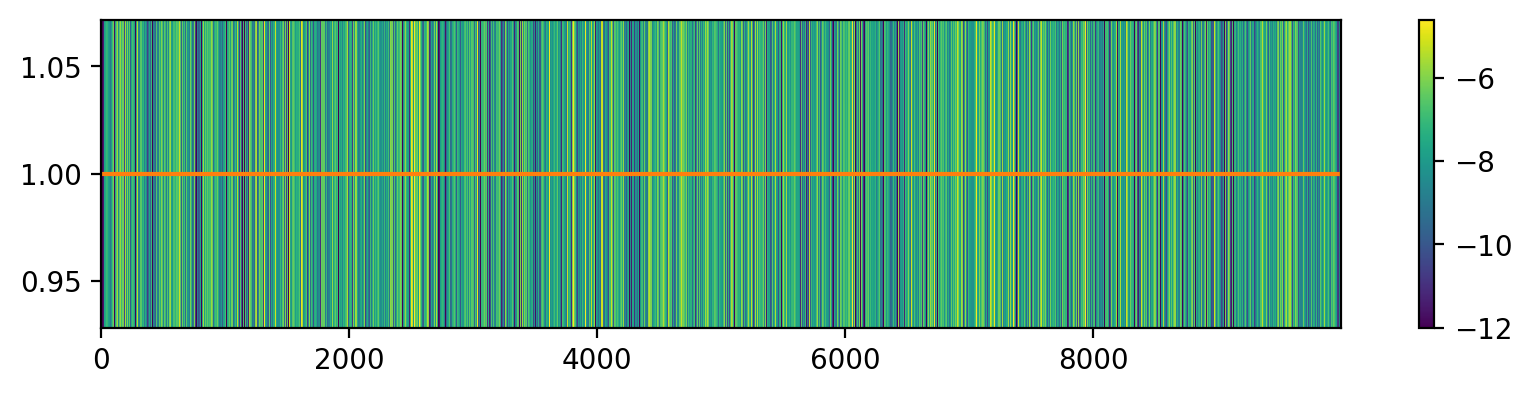

In [ ]:
plt.figure(figsize=(10,2), dpi=200)
plt.pcolormesh(list(range(Nsamples)), logmassrange, sigmargresults, vmin=-12)
plt.axhline(truelogmassval, c='tab:orange')
plt.colorbar()
plt.show()

## Calculating posterior

In [ ]:


log_posterior = []

for lambdaval in notebook_tqdm(lambdarange, total=lambdarange.shape[0]):
    log_posterior.append([np.sum(np.logaddexp(np.log(lambdaval)+sigmargresults[logmassindex,:], np.log(1-lambdaval)+bkgmargresults)) for logmassindex in range(len(list(logmassrange)))])

log_posterior = np.array(log_posterior)-special.logsumexp(log_posterior)


endertimer = time.perf_counter()
print(endertimer-startertimer)

100%|██████████| 81/81 [00:00<00:00, 98.88it/s] 

1104.047243333


# <h1><b>Plotting

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_55563/994065171.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


0.0015020818885799797
0.0009486832980505146
0.0004743416490252573
0.0003557562367689421
0.0004743416490252573
0.0005138701197773611


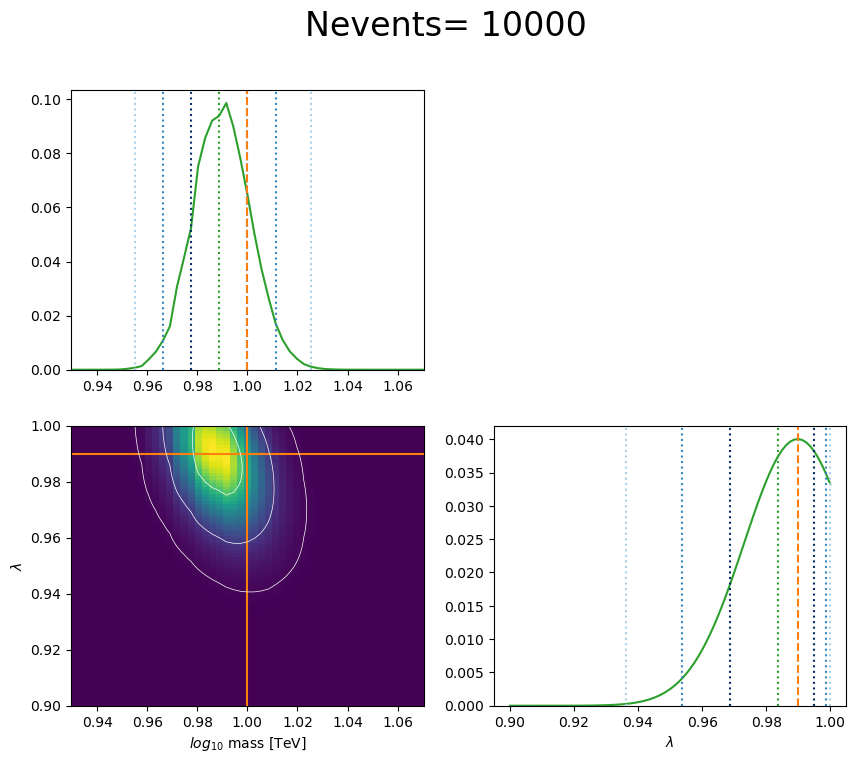

In [ ]:
from utils3d import confidence_ellipse
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {Nsamples}", size=24)

# Upper left plot
logmass_logposterior = special.logsumexp(log_posterior, axis=0)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdflogmassposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(logmasspercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(truelogmassval, ls='--', color="tab:orange")


if min(mean - logmasspercentiles)>log10eaxistrue[1]-log10eaxistrue[0]:
    for logetrueval in log10eaxistrue:
        ax[0,0].axvline(logetrueval, c='forestgreen', alpha=0.3)
ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, lambdarange, np.exp(log_posterior), vmin=0)
ax[1,0].axvline(truelogmassval, c='tab:orange')
ax[1,0].axhline(truelambda, c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\lambda$')

ax[1,0].set_ylim([lambdarange[0], lambdarange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
normed_posterior = np.exp(log_posterior)/np.exp(log_posterior).sum()
n = 100000
t = np.linspace(0, normed_posterior.max(), n)
integral = ((normed_posterior >= t[:, None, None]) * normed_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
ax[1,0].contour(normed_posterior, t_contours, extent=[logmassrange[0],logmassrange[-1], lambdarange[0],lambdarange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


lambda_logposterior = special.logsumexp(log_posterior, axis=1)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlambda = lambdarange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentile = lambdarange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()]
    lambdapercentiles.append(lambdapercentile)
    print(np.sqrt(1e5/1e8)*np.abs(lambdapercentile - meanlambda))





ax[1,1].plot(lambdarange,normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(truelambda, ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\lambda$')
ax[1,1].set_ylim([0, None])


plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{truelogmassval}_l{truelambda}_%m%d_%H%M.pdf"))
plt.show()

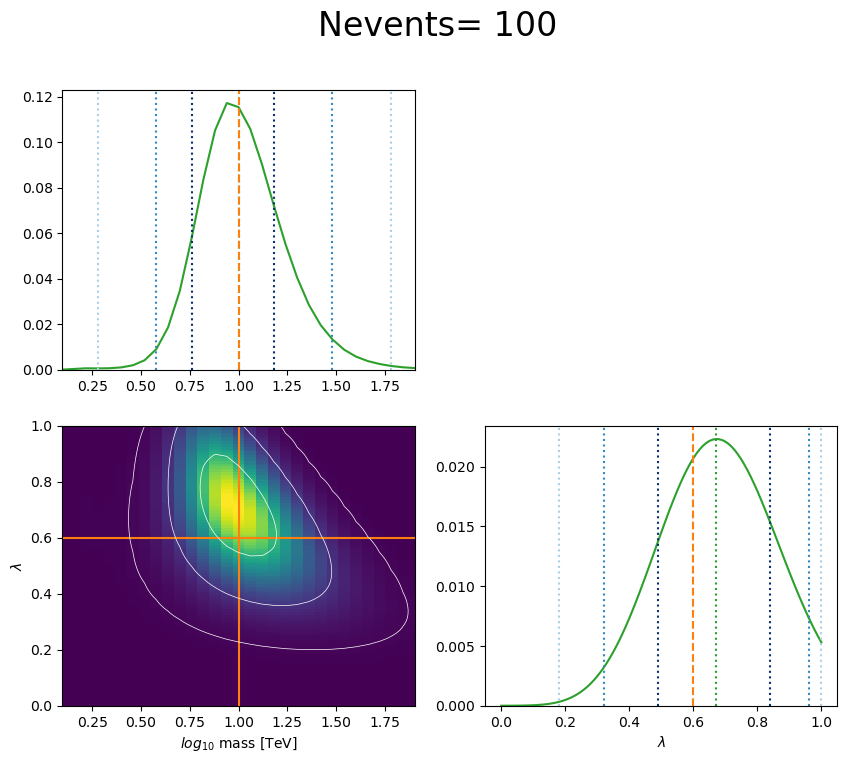

In [ ]:
import os
# os.system('say Your code is finished.')

In [ ]:
6*1e6/100/60

1000.0

In [ ]:
norm.cdf(-4)

3.167124183311986e-05